In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain-google-genai

In [ ]:
# from dotenv import load_dotenv
# load_dotenv()

from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

# Built-in functions to interrupt/resume graph computation
from langgraph.types import interrupt, Command

In [ ]:
import os
from google.colab import userdata
os.environ['GEMINI_API_KEY'] = userdata.get('GOOGLE_API_KEY')

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

@tool
def get_stock_price(symbol: str) -> float:
    '''Return the current price of a stock given the stock symbol'''
    return {"MSFT": 200.3, "AAPL": 100.4, "AMZN": 150.0, "RIL": 87.6}.get(symbol, 0.0)

@tool
def buy_stocks(symbol: str, quantity: int, total_price: float) -> str:
    '''Buy stocks given the stock symbol and quantity'''
    decision = interrupt(f"Approve buying {quantity} {symbol} stocks for ${total_price:.2f}?")

    if decision == "yes":
        return f"You bought {quantity} shares of {symbol} for a total price of {total_price}"
    else:
        return "Buying declined."


tools = [get_stock_price, buy_stocks]

In [ ]:
llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

In [ ]:
def chatbot_node(state: State):
    msg = llm_with_tools.invoke(state["messages"])
    return {"messages": [msg]}

In [ ]:
memory = MemorySaver()

builder = StateGraph(State)
builder.add_node("chatbot", chatbot_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
builder.add_edge("tools", "chatbot")
builder.add_edge("chatbot", END)
graph = builder.compile(checkpointer=memory)

config = {"configurable": {"thread_id": "buy_thread"}}

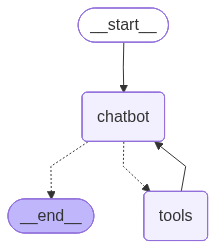

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Step 1: user asks price
state = graph.invoke({"messages":[{"role":"user","content":"What is the current price of 10 MSFT stocks?"}]}, config=config)
print(state["messages"][-1].content)

The current price of one MSFT stock is $200.3. Therefore, the current price of 10 MSFT stocks is $2003.


In [ ]:
# Step 2: user asks to buy
state = graph.invoke({"messages":[{"role":"user","content":"Buy 10 MSFT stocks at current price."}]}, config=config)
print(state.get("__interrupt__"))

[Interrupt(value='Approve buying 10 MSFT stocks for $2003.00?', id='0a55a4f847c4e7cab2014686e0e20dc3')]


In [ ]:
decision = input("Approve (yes/no): ")
state = graph.invoke(Command(resume=decision), config=config)
print(state["messages"][-1].content)

Approve (yes/no): yes
OK. You bought 10 shares of MSFT for a total price of $2003.0.


In [ ]:
config_1 = {"configurable": {"thread_id": "buy_not_thread"}}

# Step 2: user asks to buy
state = graph.invoke({"messages":[{"role":"user","content":"Buy 20 RIL stocks at current price."}]}, config=config_1)
print(state.get("__interrupt__"))

[Interrupt(value='Approve buying 20 RIL stocks for $1752.00?', id='a1ed6ad7dc09fc538094149f1c67d02d')]


In [ ]:
decision = input("Approve (yes/no): ")
state = graph.invoke(Command(resume=decision), config=config_1)
print(state["messages"][-1].content)

Approve (yes/no): no
I am sorry, I was not able to buy the stocks. Please try again later.
